In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

%matplotlib inline

DATA_ROOT = Path("../data/raw/barber")
LAP_PATH = DATA_ROOT / "R2_barber_lap_time.csv"   # <-- Race 2 timing CSV

print("Using:", LAP_PATH, "exists? ->", LAP_PATH.exists())

df_lap = pd.read_csv(LAP_PATH)
df_lap.head()
df_lap.columns

Using: ../data/raw/barber/R2_barber_lap_time.csv exists? -> True


Index(['expire_at', 'lap', 'meta_event', 'meta_session', 'meta_source',
       'meta_time', 'original_vehicle_id', 'outing', 'timestamp', 'vehicle_id',
       'vehicle_number'],
      dtype='object')

In [2]:
CAR_ID = "GR86-002-000"

df_car_off = (
    df_lap[df_lap["vehicle_id"] == CAR_ID]
    .copy()
    .sort_values("lap")
)

df_car_off["timestamp_dt"] = pd.to_datetime(df_car_off["timestamp"])
df_car_off["lap_time_official_s"] = (
    df_car_off["timestamp_dt"].diff().dt.total_seconds()
)

df_car_off[["lap", "timestamp_dt", "lap_time_official_s"]].head()

,lap,timestamp_dt,lap_time_official_s
0,1,2025-09-07 15:05:48.003000+00:00,NaN
1,2,2025-09-07 15:07:27.981000+00:00,99.978
2,3,2025-09-07 15:09:06.304000+00:00,98.323
3,4,2025-09-07 15:10:44.473000+00:00,98.169
4,5,2025-09-07 15:12:22.323000+00:00,97.850


In [4]:
merged = pd.merge(
    lap_feats[["lap", "lap_time_s"]],
    df_car_off[["lap", "lap_time_official_s"]],
    on="lap",
    how="inner",
).sort_values("lap")

merged = merged.rename(columns={"lap_time_s": "lap_time_telemetry_s"})
merged.head()

,lap,lap_time_telemetry_s,lap_time_official_s
0,1,48.881,NaN
1,2,99.942,99.978
2,3,98.273,98.323
3,4,98.130,98.169
4,5,97.759,97.850


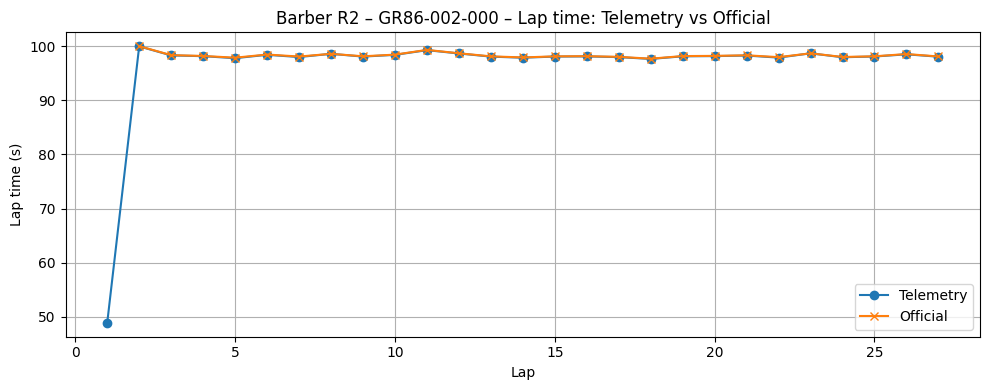

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(merged["lap"], merged["lap_time_telemetry_s"], marker="o", label="Telemetry")
ax.plot(merged["lap"], merged["lap_time_official_s"], marker="x", label="Official")
ax.set_title(f"Barber R2 – {CAR_ID} – Lap time: Telemetry vs Official")
ax.set_xlabel("Lap")
ax.set_ylabel("Lap time (s)")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

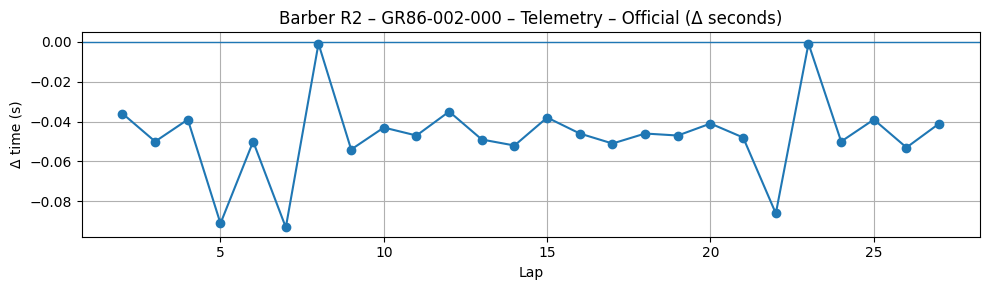

count    26.000000
mean     -0.047192
std       0.020519
min      -0.093000
25%      -0.050750
50%      -0.047000
75%      -0.039500
max      -0.001000
Name: delta_s, dtype: float64

In [6]:
merged["delta_s"] = merged["lap_time_telemetry_s"] - merged["lap_time_official_s"]

fig, ax = plt.subplots(figsize=(10, 3))
ax.axhline(0, linewidth=1)
ax.plot(merged["lap"], merged["delta_s"], marker="o")
ax.set_title(f"Barber R2 – {CAR_ID} – Telemetry – Official (Δ seconds)")
ax.set_xlabel("Lap")
ax.set_ylabel("Δ time (s)")
ax.grid(True)
plt.tight_layout()
plt.show()

merged["delta_s"].describe()

### Barber R2 – Telemetry vs Official Timing (Validation)

For Barber Race 2, the per-lap times reconstructed from telemetry closely match
the official timing loops:

- Telemetry – Official has **mean Δ ≈ –0.047 s** (telemetry slightly faster),
  with **std ≈ 0.02 s**, and all laps within about **±0.1 s**.
- The Δ series shows no drift or structural bias over the race; differences are
  small and mostly random.

**Conclusion:** the R2 telemetry + lap reconstruction pipeline is accurate
enough to use for strategy and driver-insight analysis, just like R1.